In [6]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import fetch_20newsgroups
import networkx as nx
from itertools import combinations
from typing import List, Set, Tuple
import seaborn as sns
from scipy.cluster.hierarchy import linkage, leaves_list
from wordcloud import WordCloud


categories = [
    "alt.atheism",
    "talk.religion.misc",
    "comp.graphics",
    "sci.space",
    "rec.sport.hockey",
    "soc.religion.christian"
]

dataset = fetch_20newsgroups(
    remove=("headers", "footers", "quotes"),
    subset="train",
    categories=categories,
    shuffle=True,
    random_state=42,
)

org_data = []
labels = []

indices = np.arange(len(dataset.target))
np.random.shuffle(indices)
org_data = np.array(dataset.data)[indices[:300]]
labels = dataset.target[indices[:300]]

org_data = np.array(org_data)
labels = np.array(labels)
unique_labels, category_sizes = np.unique(labels, return_counts=True)
true_k = unique_labels.shape[0]

print(f"{len(org_data)} documents - {true_k} categories")

300 documents - 6 categories


In [7]:
org_data[4]

"-=> Quoting Cire Y. Trehguad to All <=-\n : >And, while we are on the subject, has a captain ever been traded, \n : >resigned, or been striped of his title during the season? Any other \n : >team captain trivia would be appreciated.\n CYT> ;\n CYT> : Wasn't Ron Francis captain of the Whalers when he was traded to\n CYT> : Pittsburgh?\n\n CYT> And Rick Tochett was the captain of the Flyers when traded to the Pens\n CYT> recently...\n\n CYT> Caleb\n\n CYT> And let us not forget that the New Jersey Devils traded\n CYT> captain Kirk Muller for Stephen Richer and Chorske\n\n CYT> Man I hated that trade!\n\n\n        Well as for team captains being traded\n        in there first year in the NHL the\n        Edmonton Oilers traded their captain\n        Ron Chiperfield to the Quebec Nordique\n        right at the trading deadline for \n        Goaltender Ron Lowe\n        In their second year of existence\n        The Edmonton Oilers again right at the trade \n        deadline traded their c

In [8]:
from sklearn.feature_extraction.text import TfidfVectorizer
from time import time

vectorizer = TfidfVectorizer(
    max_df=0.5,
    min_df=4,
    stop_words="english",
)
t0 = time()
X_tfidf = vectorizer.fit_transform(org_data)

print(f"vectorization done in {time() - t0:.3f} s")
print(f"n_samples: {X_tfidf.shape[0]}, n_features: {X_tfidf.shape[1]}")

vectorization done in 0.117 s
n_samples: 300, n_features: 1705


In [9]:
data = np.array(X_tfidf.todense())
n_samples, n_features = data.shape

In [10]:
n_samples, n_features

(300, 1705)

Text(0.5, 0, 'features')

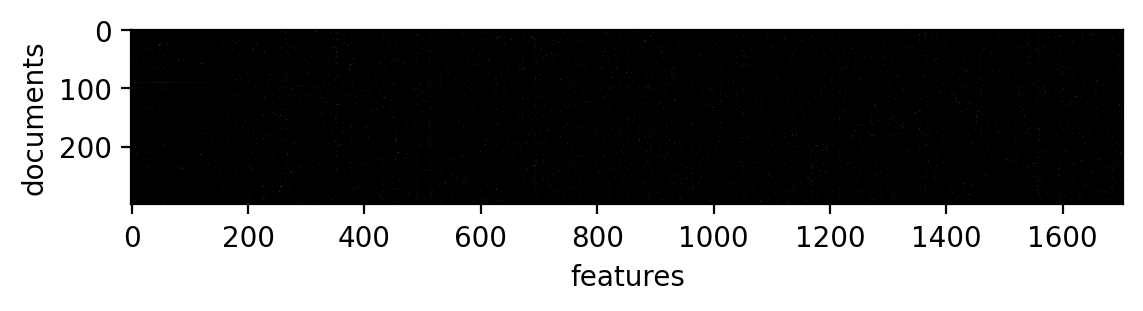

In [11]:
plt.figure(dpi = 200)
plt.imshow(data, cmap = "gray")
plt.ylabel("documents")
plt.xlabel("features")

In [12]:
def row_normalization(data: np.array) -> np.array:
    row_average = data.mean(axis = 0)[None, :]
    centered_data = data - row_average
    normalized_length = centered_data / np.linalg.norm(centered_data, axis=1)[:, None]
    return normalized_length

def column_normalization(data: np.array) -> np.array:
    column_average = data.mean(axis = 1)[:, None]
    centered_data = data - column_average
    normalized_length = centered_data / np.linalg.norm(centered_data, axis = 0)[None, :]
    return normalized_length


def vector_to_set(vector: np.ndarray) -> Set[int]:
    """
    Convert a binary or weighted vector to a set of indices with non-zero values.

    Parameters:
    - vector: 1D NumPy array.

    Returns:
    - Set of indices where the vector has non-zero values.
    """
    return set(np.nonzero(vector)[0])

def jaccard_similarity(set1: Set[int], set2: Set[int]) -> float:
    """
    Compute the Jaccard similarity between two sets.

    Parameters:
    - set1: First set.
    - set2: Second set.

    Returns:
    - Jaccard similarity as a float.
    """
    intersection = set1.intersection(set2)
    union = set1.union(set2)
    if not union:
        return 0.0
    return len(intersection) / len(union)

def fuse_fixed_points_vectors(
    feature_vectors: np.ndarray,
    sample_vectors: np.ndarray,
    similarity_threshold: float = 0.7
) -> Tuple[List[Set[int]], List[Set[int]]]:
    """
    Fuse similar fixed points based on their feature and sample vectors.

    Parameters:
    - feature_vectors: 2D NumPy array where each row represents a feature vector for a fixed point.
                       Columns correspond to features.
    - sample_vectors: 2D NumPy array where each row represents a sample vector for a fixed point.
                      Columns correspond to samples.
    - similarity_threshold: Threshold above which fixed points are considered similar.

    Returns:
    - fused_features_list: List of sets, each representing fused features in a module.
    - fused_samples_list: List of sets, each representing fused samples in a module.
    """
    if feature_vectors.shape[0] != sample_vectors.shape[0]:
        raise ValueError("feature_vectors and sample_vectors must have the same number of fixed points (rows).")
    
    num_fixed_points = feature_vectors.shape[0]
    G = nx.Graph()
    G.add_nodes_from(range(num_fixed_points))  # Nodes are indices of fixed points

    # Precompute sets for all fixed points
    feature_sets = [vector_to_set(feature_vectors[i]) for i in range(num_fixed_points)]
    sample_sets = [vector_to_set(sample_vectors[i]) for i in range(num_fixed_points)]

    # Iterate over all unique pairs to compute similarity
    for i, j in combinations(range(num_fixed_points), 2):
        feature_sim = jaccard_similarity(feature_sets[i], feature_sets[j])
        sample_sim = jaccard_similarity(sample_sets[i], sample_sets[j])
        # Define overall similarity as the average of feature and sample similarity
        overall_sim = (feature_sim + sample_sim) / 2
        if overall_sim >= similarity_threshold:
            G.add_edge(i, j)

    # Find connected components (clusters of similar fixed points)
    clusters = list(nx.connected_components(G))

    fused_features_list = []
    fused_samples_list = []

    for cluster in clusters:
        fused_features = set()
        fused_samples = set()
        for idx in cluster:
            fused_features.update(feature_sets[idx])
            fused_samples.update(sample_sets[idx])
        fused_features_list.append(fused_features)
        fused_samples_list.append(fused_samples)

    return fused_features_list, fused_samples_list
    

def display_fused_modules(
    fused_features: List[Set[int]],
    fused_samples: List[Set[int]],
    feature_labels: List[str],
    sample_labels: List[str]
):
    """
    Display the fused modules with feature and sample labels.

    Parameters:
    - fused_features: List of sets containing feature indices.
    - fused_samples: List of sets containing sample indices.
    - feature_labels: List mapping feature indices to feature names.
    - sample_labels: List mapping sample indices to sample names.
    """
    for i, (features, samples) in enumerate(zip(fused_features, fused_samples), 1):
        feature_names = [feature_labels[idx] for idx in features]
        sample_names = [sample_labels[idx] for idx in samples]
        print(f"Fused Module {i}:")
        print(f"  Features: {sorted(feature_names)}")
        print(f"  Samples: {sorted(sample_names)}\n")

  
    
def ISA(data: np.array, n_initial: int = 1000, n_updates = 1000, thresh_feature: int = 0, thresh_sample: int = 0, fusion_similarity_threshold: float = 0.8):

    def W(x: np.array) -> np.array:
        return x

    def threshold(x: np.array, t: int) -> np.array:
        s = np.std(x)
        new_x = (x - np.mean(x))/(s if (s!=0 and not np.isinf(s)) else 1)
        return (new_x > t).astype(int)
    
    def f(x: np.array, t_feature: int = None, t_sample: int = None) -> np.array:
        return W(x) * threshold(x = x, t = t_feature) if t_feature is not None else W(x) * threshold(x = x, t = t_sample) 


    n_samples, n_features = data.shape
    
    r_data = row_normalization(data)
    c_data = column_normalization(data)

    feature_vector = np.zeros((n_features))
    sample_vector = np.zeros((n_samples))

    all_feature_vectors = []
    all_sample_vectors = []
    for _ in range(n_initial):
        seed = np.random.binomial(n = 1, p = 0.5, size = n_features)
        feature_vector = seed
        for i in range(n_updates):
            sample_vector = f(r_data.dot(feature_vector), t_sample = thresh_sample)
            feature_vector = f(c_data.T.dot(sample_vector), t_feature = thresh_feature)
            
        all_feature_vectors.append(feature_vector)
        all_sample_vectors.append(sample_vector)

    all_feature_vectors = np.array(all_feature_vectors)
    all_sample_vectors = np.array(all_sample_vectors)


    # Perform fusion
    fused_features, fused_samples = fuse_fixed_points_vectors(
        all_feature_vectors,
        all_sample_vectors,
        fusion_similarity_threshold
    )

    return fused_samples, fused_features
            

In [51]:
sample_vec, feature_vec = ISA(data, n_initial=2000, n_updates=20, thresh_feature=1.6, thresh_sample=1.1, fusion_similarity_threshold = 0.7 )

In [52]:
display_fused_modules(fused_features = feature_vec, fused_samples=sample_vec, feature_labels=vectorizer.get_feature_names_out(), sample_labels=labels)

Fused Module 1:
  Features: ['01', '04', '08', '10', '11', '22', '93', '95', '96', '97', 'ames', 'apollo', 'archive', 'assist', 'astronomy', 'atmosphere', 'atmospheric', 'com', 'crew', 'data', 'dec', 'december', 'designed', 'detailed', 'discovered', 'dynamics', 'earth', 'edu', 'esa', 'eventually', 'exploration', 'failed', 'field', 'flight', 'flybys', 'gov', 'gravity', 'images', 'information', 'japan', 'joint', 'jp', 'june', 'jupiter', 'launch', 'launched', 'lunar', 'major', 'mapping', 'mars', 'mission', 'missions', 'moon', 'nasa', 'objectives', 'october', 'orbit', 'orbital', 'orbiter', 'orbiting', 'outer', 'phone', 'pioneer', 'planet', 'planetary', 'planets', 'primarily', 'probes', 'propulsion', 'ray', 'return', 'returned', 'rocket', 'satellite', 'schedule', 'scheduled', 'science', 'sent', 'shuttle', 'sky', 'soft', 'solar', 'space', 'spacecraft', 'specific', 'stars', 'study', 'successful', 'sun', 'surface', 'telescope', 'titan', 'training', 'updated', 'venus', 'wide']
  Samples: [1, 2,

In [53]:
dataset.target_names

['alt.atheism',
 'comp.graphics',
 'rec.sport.hockey',
 'sci.space',
 'soc.religion.christian',
 'talk.religion.misc']

In [54]:
words = vectorizer.get_feature_names_out()

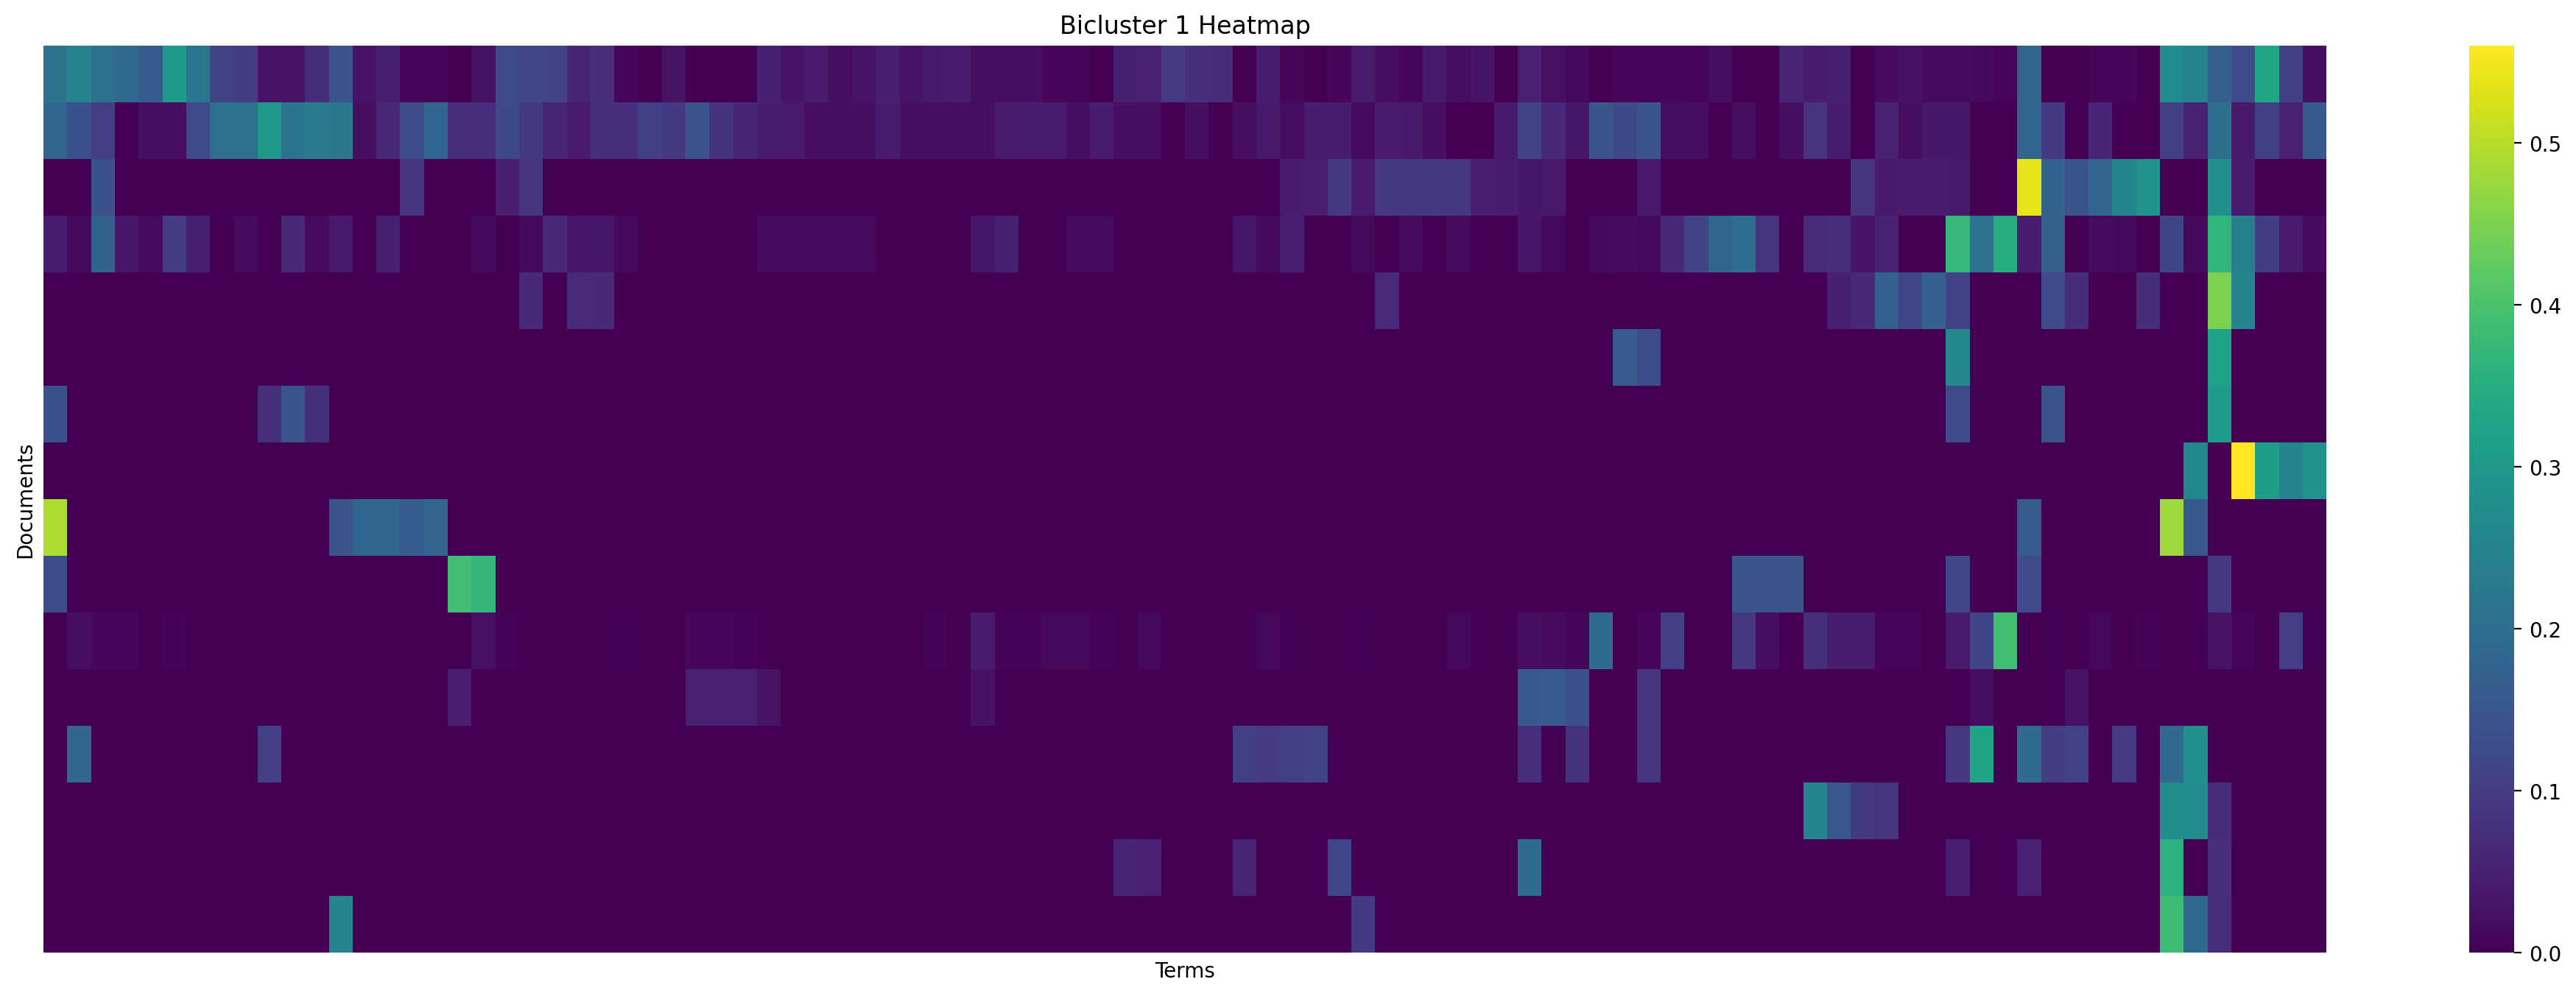

In [98]:
ind = 0
samples, features  = sorted(list(sample_vec[ind])), sorted(list(feature_vec[ind]))
bicluster  = data[samples][:, features]

# Perform hierarchical clustering for rows and columns
row_linkage = linkage(bicluster, method='ward')
col_linkage = linkage(bicluster.T, method='ward')

# Get the order of rows and columns based on the clustering
row_order = leaves_list(row_linkage)
col_order = leaves_list(col_linkage)

# Reorder the data based on clustering
reordered_data = bicluster[row_order, :][:, col_order]

plt.figure(figsize=(25,8), dpi = 200)
sns.heatmap(reordered_data, cmap="viridis", annot=False)
plt.title(f"Bicluster {ind + 1} Heatmap")
plt.xlabel("Terms")
plt.ylabel("Documents")
plt.xticks([])
plt.yticks([])
plt.show()

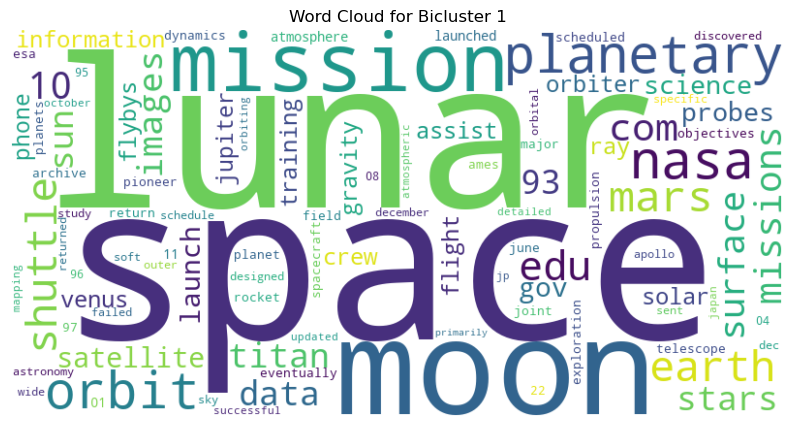

In [95]:
ind = 0
samples, features  = sorted(list(sample_vec[ind])), sorted(list(feature_vec[ind]))

bicluster_terms = {words[word_ind]: np.mean(data[samples, :][:, word_ind]) for word_ind in features}
wordcloud = WordCloud(width=800, height=400, background_color="white").generate_from_frequencies(bicluster_terms)

plt.figure(figsize=(10, 6))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.title(f"Word Cloud for Bicluster {ind + 1}")
plt.show()

In [92]:
from sklearn.manifold import TSNE
import umap

def manifold(sample_vec: List[Set[int] or np.ndarray], feature_vec: List[Set[int] or np.ndarray], title: str, manifold_learner: str = "tsne", random_state: int = 42) -> None:
    solution = []
    cluster_labels = []
    
    all_features = set()
    
    for i in range(len(feature_vec)):
        all_features.update(feature_vec[i])
    
    all_features = sorted(list(all_features))
    
    for i in range(len(sample_vec)):
        samples = sorted(list(sample_vec[i]))
        solution.extend(data[samples, :][:, all_features])
        cluster_labels.extend([i+1]*len(sample_vec[i]))
    
    solution = np.array(solution)
    solution = row_normalization(solution)

    if manifold_learner == "tsne":
        tsne = TSNE(n_components=2, random_state=random_state)
        embedded = tsne.fit_transform(solution)
    elif manifold_learner == "umap":
        reducer = umap.UMAP(random_state=random_state)
        embedded = reducer.fit_transform(solution)
    else:
        raise ValueError("Manifold learner can be tsne or umap!")
        
    plt.figure(figsize=(10, 6))
    for i, cluster_label in enumerate(set(cluster_labels)):
        cluster_points = embedded[np.array(cluster_labels) == cluster_label]
        plt.scatter(cluster_points[:, 0], cluster_points[:, 1], label=f"Cluster {i+1}")
    plt.title(title)
    plt.legend()
    plt.show()


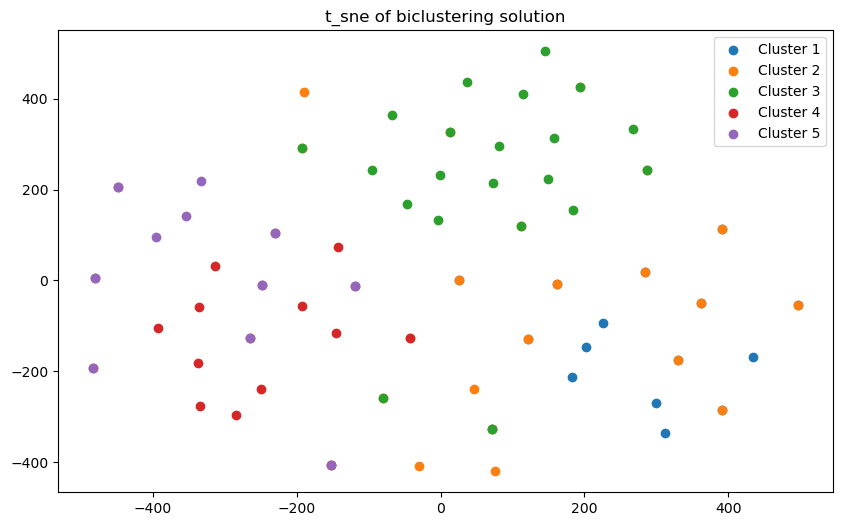

In [79]:
manifold(sample_vec, feature_vec, "t_sne of biclustering solution")

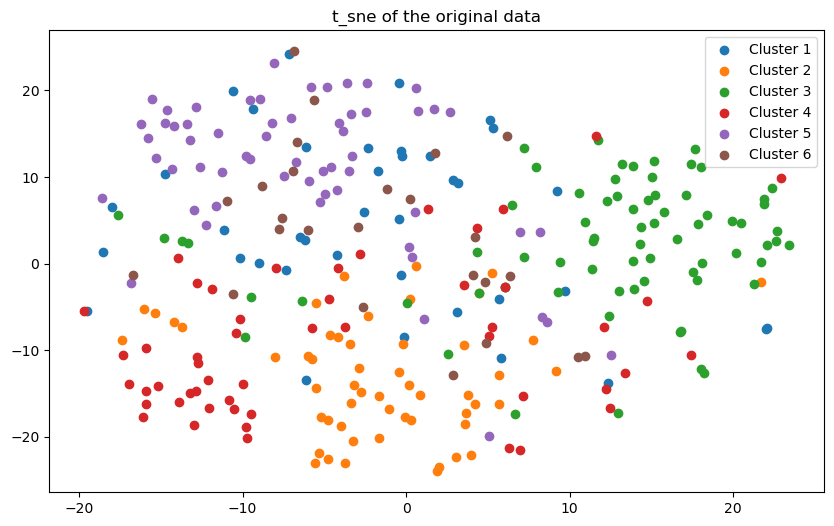

In [82]:
manifold([np.where(labels == label)[0] for label in np.unique(labels)], np.array([np.arange(n_features) for label in labels]), "t_sne of the original data")

/Users/saleh/opt/anaconda3/envs/test/lib/python3.10/site-packages/umap/umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


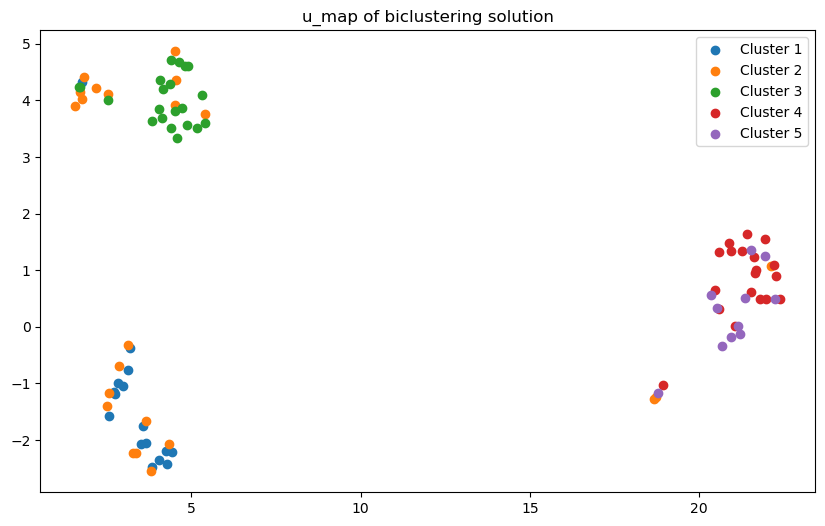

In [94]:
manifold(sample_vec, feature_vec, "u_map of biclustering solution", manifold_learner="umap")

/Users/saleh/opt/anaconda3/envs/test/lib/python3.10/site-packages/umap/umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


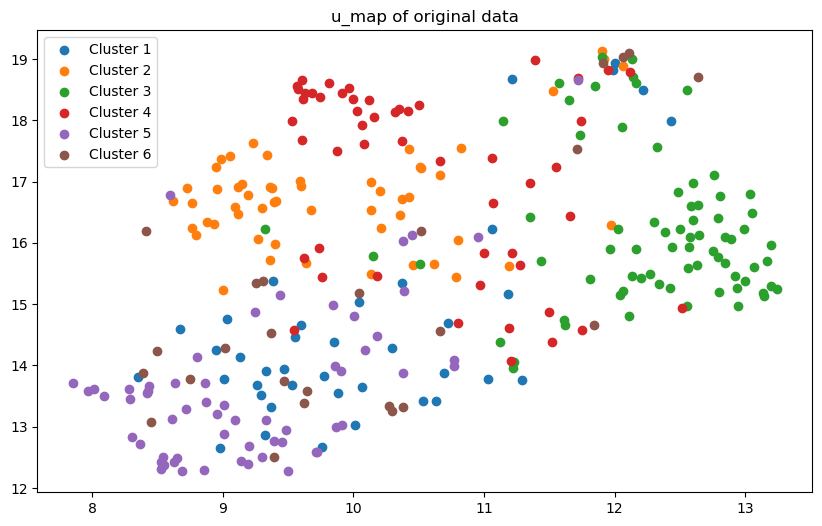

In [93]:
manifold([np.where(labels == label)[0] for label in np.unique(labels)], np.array([np.arange(n_features) for label in labels]), "u_map of original data", manifold_learner="umap")